In [ ]:
# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set device to gpu if available
import torch
device = 'cpu'
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')
  

All good, a Gpu is available


In [ ]:
!nvidia-smi

Sun May  8 12:43:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric
!pip install -q ogb

In [ ]:
# Import modules
import networkx as nx
from torch_geometric.utils.convert import to_networkx

import tqdm
import time
import sys
import os
import math
import random

import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.utils import negative_sampling

import numpy as np

import pandas as  pd

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm, colors

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator 

from sklearn.metrics import roc_auc_score

## Reproducibility
When **developing and debugging** Neural Networks is desirable to have a deterministic behaviour. For this reason, we are going to disable all the sources of randomness. Please note that completely reproducible results are not guaranteed across PyTorch releases, individual commits or different platforms. You can find more detailed information at this [page](https://pytorch.org/docs/stable/notes/randomness.html).
Please note that the flag `cudnn.benchmark = False` disable the auto-tuner that selects the optimal set of algorithms for your hardware and usually leads to slower runtime. 

In [ ]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True        

In [ ]:
fix_random(42)

## The Dataset

In [ ]:
# dataset = PygLinkPropPredDataset(name="ogbl-ddi", root='datasets/')
# evaluator = Evaluator(name='ogbl-ddi')

In [ ]:
dataset = PygLinkPropPredDataset(name="ogbl-collab", root='datasets/')
evaluator = Evaluator(name='ogbl-collab')

In [ ]:
# dataset = PygLinkPropPredDataset(name="ogbl-ppa", root='datasets/')
# evaluator = Evaluator(name='ogbl-ppa')

In [ ]:
data = dataset[0]

In [ ]:
print()
print(f'Dataset: {dataset.name}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print()
print(data)
print('=======================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: ogbl-collab:
Number of graphs: 1
Number of features: 128
Number of classes: 0

Data(num_nodes=235868, edge_index=[2, 2358104], x=[235868, 128], edge_weight=[2358104, 1], edge_year=[2358104, 1])
Number of nodes: 235868
Number of edges: 2358104
Average node degree: 10.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
import torch_geometric.transforms as T

# Normalize features
transform = T.Compose([
    T.NormalizeFeatures(),
    T.RemoveIsolatedNodes(),
])
data.x = data.x.float()
data = transform(data)

In [ ]:
edge_index = data.edge_index

# Retrieve edges splits for train, validation and test
split_edge = dataset.get_edge_split()

pos_train_edge = split_edge['train']['edge'].to(device)

pos_val_edge = split_edge['valid']['edge'].to(device)
neg_val_edge = split_edge['valid']['edge_neg'].to(device)

pos_test_edge = split_edge['test']['edge'].to(device)
neg_test_edge = split_edge['test']['edge_neg'].to(device)

In [ ]:
'''
NeighborSampler iteratively samples neighbors and constructs bipartite graphs
that simulate the actual computation flow of GNNs.
More specifically, sizes denotes how much neighbors we want to sample for each node in each layer.
Hence, an item returned by NeighborSampler holds the current batch_size, the IDs
n_id of all nodes involved in the computation, and a list of bipartite graph objects
via the tuple (edge_index, e_id, size), where edge_index represents the bipartite edges
between source and target nodes, e_id denotes the IDs of original edges in the full graph,
and size holds the shape of the bipartite graph. For each bipartite graph,
target nodes are also included at the beginning of the list of source nodes
so that one can easily apply skip-connections or add self-loops.
'''
from torch_geometric.loader import NeighborSampler

train_loader = NeighborSampler(
    data.edge_index,
    node_idx=None,
    # For each node pick all neighbors at 1-hops and 10 neighors
    # at 2-hops (10 is the mean node degree for this dataset)
    sizes=[-1, 10],    
    batch_size=512,
    shuffle=False,
    num_workers=12
)

subgraph_loader = NeighborSampler(
    data.edge_index,
    node_idx=None,
    sizes=[-1],
    batch_size=512,
    shuffle=False,
    num_workers=12
)

In [ ]:
# sum = 0
# for batch_size, n_id, adjs in train_loader:
#     edge_index, _, size = adjs[-1]
#     sum += size[1]
# print(sum)
# print(data.num_nodes)

##Model Definition

In [ ]:
from torch.nn import Sequential, Linear, Dropout
from torch_geometric.nn.conv import SAGEConv
class SAGE(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, p_drop, n_layers, skip_conn=False, post_proc_MLP=False, return_embedding=False):
        super(SAGE, self).__init__()

        if n_layers < 1:
            raise AssertionError('Number or convolution layer must be at least 1')
        
        self.p_drop = p_drop
        self.n_layers = n_layers
        self.skip_conn = skip_conn
        self.return_embedding = return_embedding

        self.convs = torch.nn.ModuleList()
        for i in range(n_layers):
            conv = SAGEConv(in_dim, hid_dim, normalize=True, aggr="add")
            in_dim = hid_dim
            self.convs.append(conv)
        
        self.post_proc_MLP = post_proc_MLP
        if post_proc_MLP:
            self.post_MLP = Sequential(
                Linear(in_dim, hid_dim), Dropout(self.p_drop),
                Linear(hid_dim, out_dim)
            )
        else:
            self.convs[-1] = SAGEConv(in_dim, out_dim, normalize=True, aggr="add")
    
    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        self.post_MLPs.reset_parameters()
    
    def forward(self, x, adjs):
        x_prev = None

        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.
        for i in range(self.n_layers):
            edge_index, _, size = adjs[i]
            x_target = x_prev = x[:size[1]]  # Target nodes are always placed first.

            x = self.convs[i]((x, x_target), edge_index)

            if self.skip_conn and i != 0 and i != self.n_layers-1:
                x = x + x_prev
            
            if i != self.n_layers - 1 or self.post_proc_MLP:
                x = F.relu(x)
                x = F.dropout(x, p=self.p_drop, training=self.training)
            
        
        if self.post_proc_MLP:
            x = self.post_MLP(x)
            
        embedding = x

        if self.return_embedding:
            return embedding
        else:
            return F.log_softmax(embedding, dim=1)

    def inference(self, x_all):
        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        x_prev = None
        for i in range(self.n_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x_prev = x[:size[1]]

                x = self.convs[i]((x, x_target), edge_index)

                if self.skip_conn and i != 0 and i != self.n_layers-1:
                    x = x + x_prev
            
                if i != self.n_layers - 1 or self.post_proc_MLP:
                    x = F.relu(x)

                xs.append(x.cpu())
            
            x_all = torch.cat(xs, dim=0)
            
            
        if self.post_proc_MLP:
            x_all = self.post_MLP(x_all.to(device))

        return x_all.cpu()

The LinkPredictor takes the embedding vector of 2 nodes ($h_i$, $h_j \in \mathbb{R}^d$ ) and computes the probability score of whether there exists a link between the 2 nodes.

$$\text{Probability of edge between node i and node j = MLP}(h_i\odot h_j)$$

Note: $x \odot y$ is the element-wise product (Hadamard product) of vectors $x$ and $y$

In [ ]:
from torch.nn import Linear
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hid_channels, out_channels, n_layers, p_drop):
        super(LinkPredictor, self).__init__()

        # Create linear layers
        self.lins = torch.nn.ModuleList()
        self.lins.append(Linear(in_channels, hid_channels))
        for _ in range(n_layers - 2):
            self.lins.append(Linear(hid_channels, hid_channels))
        self.lins.append(Linear(hid_channels, out_channels))

        self.p_drop = p_drop

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        # x_i and x_j are both of shape (E, D)
        x = (x_i * x_j).to(device)

        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.p_drop, training=self.training)
        x = self.lins[-1](x)
        
        return torch.sigmoid(x)

## Train and evaluation

The model is trained by jointly maximizing the probabilty prediction of correct edges and minimizing the probability prediciton of the incorrect edges:

$Loss = -\log(prob\_pos\_edges  + ϵ) - \log(1-prob\_neg\_edges + ϵ)$ where the $ϵ=10^{-15}$ is added to each term for numerical stability

In [ ]:
def train(model, link_predictor, node_feats, edge_index, batch_size, optimizer):
    model.train()
    link_predictor.train()

    train_losses = []
    for edge_id in DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True):
        optimizer.zero_grad()

        node_emb = []
        for _, n_id, adjs in train_loader:
            # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
            adjs = [adj.to(device) for adj in adjs]

            emb = model(node_feats[n_id].to(device), adjs)
            
            node_emb.append(emb.cpu())

        node_emb = torch.cat(node_emb, dim=0)

        # Predict the class probabilities on the batch of positive edges using link_predictor
        pos_edge = pos_train_edge[edge_id].T
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])

        # Sample negative edges (same number as number of positive edges) and predict class probabilities 
        neg_edge = negative_sampling(
            edge_index=edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=batch_size,
            method='sparse')
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])

        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()
        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    return sum(train_losses) / len(train_losses)

The performance of a link predictor is evaluated through the metric Hits@K.

Hits@K = Fraction of correct links in the top K links (with respect to their scores)

In [ ]:
@torch.no_grad()
def test(model, link_predictor, node_feats, edge_index, batch_size, evaluator):
    model.eval()
    link_predictor.eval()

    node_emb = model.inference(node_feats)

    # ---------------- VALIDATION ---------------- #
    # Positive edges prediction
    pos_val_preds = []
    for perm in DataLoader(range(pos_val_edge.size(0)), batch_size, shuffle=False):
        edge = pos_val_edge[perm].T
        pos_val_preds += [link_predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    pos_val_pred = torch.cat(pos_val_preds, dim=0)
    # Negative sampled edges prediction
    neg_val_preds = []
    for perm in DataLoader(range(neg_val_edge.size(0)), batch_size, shuffle=False):
        edge = neg_val_edge[perm].T
        neg_val_preds += [link_predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    neg_val_pred = torch.cat(neg_val_preds, dim=0)

    # ------------------- TEST ------------------- #
    # Positive edges prediction
    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size, shuffle=False):
        edge = pos_test_edge[perm].T
        pos_test_preds += [link_predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)
    # Negative sampled edges prediction
    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size, shuffle=False):
        edge = neg_test_edge[perm].T
        neg_test_preds += [link_predictor(node_emb[edge[0]], node_emb[edge[1]]).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    results = {}
    # hits@K
    for K in [20, 50, 100]:
        evaluator.K = K
        val_hits = evaluator.eval({
            'y_pred_pos': pos_val_pred,
            'y_pred_neg': neg_val_pred,
        })[f'hits@{K}']
        test_hits = evaluator.eval({
            'y_pred_pos': pos_test_pred,
            'y_pred_neg': neg_test_pred,
        })[f'hits@{K}']

        results[f'Hits@{K}'] = (round(val_hits,2), round(test_hits,2))
    # auc
    results['val_auc'] = round(roc_auc_score(
        y_true = np.concatenate((np.ones(pos_val_pred.size(0), dtype=int), np.zeros(neg_val_pred.size(0), dtype=int))),
        y_score = np.concatenate((pos_val_pred.numpy(), neg_val_pred.numpy())) 
    ), 2)
    results['test_auc'] = round(roc_auc_score(
        y_true = np.concatenate((np.ones(pos_test_pred.size(0), dtype=int), np.zeros(neg_test_pred.size(0), dtype=int))),
        y_score = np.concatenate((pos_test_pred.numpy(), neg_test_pred.numpy()))
    ), 2)
    return results

In [ ]:
BATCH_SIZE = 64 * 1024
INPUT_DIM = dataset.num_features
OUTPUT_DIM = dataset.num_classes
EPOCHS = 100
LR = 5e-3
WD = 1e-5

best_test_hits = 0
best_model_history = None
best_model_weight = None

from sklearn.model_selection import ParameterGrid
configs = {
    'USE_EMBEDDING_LAYER': [True, False],
    'HIDDEN_DIM' : [128],
    'DROPOUT' : [0.5],
    'N_LAYERS' : [2],
    'SKIP_CONN' : [False],
    'POST_PROC_MLP' : [False]
}
param_grid = ParameterGrid(configs)
print(f'Number of combinations: {len(param_grid)}')
print('------------------')
for dict_ in param_grid:
    print(f'Trying configuration {dict_}')
    parameter_list = []

    #INPUT DATA
    if dict_['USE_EMBEDDING_LAYER']:
        emb = torch.nn.Embedding(data.num_nodes, INPUT_DIM).to(device)
        if data.num_features > 0:
            emb.weight.data.copy_(data.x) # copy data features as initial embedding
        input_data = emb.weight
        parameter_list += (list(emb.parameters()))
    else:
        input_data = data.x

    #MODEL
    model = SAGE(INPUT_DIM, dict_['HIDDEN_DIM'], dict_['HIDDEN_DIM'], dict_['DROPOUT'], dict_['N_LAYERS'], dict_['SKIP_CONN'], dict_['POST_PROC_MLP'], return_embedding=True).to(device)
    parameter_list += (list(model.parameters()))
    
    #LINK PREDICTOR
    link_predictor = LinkPredictor(dict_['HIDDEN_DIM'], dict_['HIDDEN_DIM'], 1, 3, dict_['DROPOUT']).to(device)
    parameter_list += (list(link_predictor.parameters()))

    optimizer = torch.optim.Adam(parameter_list, lr=LR, weight_decay=WD)

    #TRAIN & EVALUATE
    history = {}
    history['loss'] = []
    history['val_hits@20'] = []
    history['test_hits@20'] = []
    pbar = tqdm.tqdm(range(EPOCHS))
    for epoch in pbar:
        loss = train(model, link_predictor, input_data, edge_index, BATCH_SIZE, optimizer) 
        history['loss'].append(loss)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            result = test(model, link_predictor, input_data, edge_index, BATCH_SIZE, evaluator)
            history['val_hits@20'].append(result['Hits@20'][0])
            history['test_hits@20'].append(result['Hits@20'][1])

        description = f"Epoch {epoch + 1} - loss: {round(loss, 5):.4f} - result: {result}\t"
        pbar.set_description(description, refresh=True)

    print('------------------')
    
    if max(history['test_hits@20']) > best_test_hits:
        best_parameters = dict_
        best_model_history = history
        best_model_weights = model.state_dict()
    
    del model; del link_predictor
    torch.cuda.empty_cache()

Number of combinations: 2
------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 128, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False, 'USE_EMBEDDING_LAYER': True}


Epoch 100 - loss: 0.0159 - result: {'Hits@20': (0.45, 0.36), 'Hits@50': (0.57, 0.47), 'Hits@100': (0.63, 0.54), 'val_auc': 0.96, 'test_auc': 0.95}	: 100%|██████████| 100/100 [3:39:03<00:00, 131.43s/it]


------------------
Trying configuration {'DROPOUT': 0.5, 'HIDDEN_DIM': 128, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False, 'USE_EMBEDDING_LAYER': False}


  0%|          | 0/100 [00:16<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
print(f'Best parameters: {best_parameters}')

Best parameters: {'DROPOUT': 0.5, 'HIDDEN_DIM': 128, 'N_LAYERS': 2, 'POST_PROC_MLP': False, 'SKIP_CONN': False, 'USE_EMBEDDING_LAYER': True}


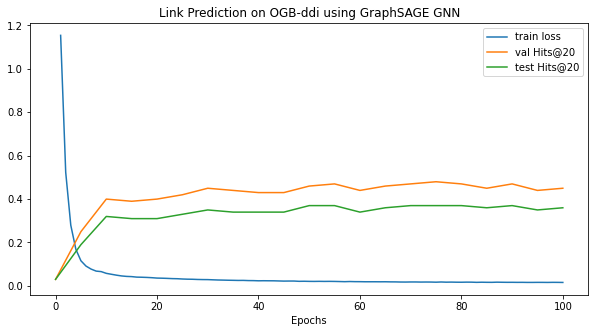

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, EPOCHS+1), best_model_history['loss'], label="train loss")
plt.plot(np.arange(0, EPOCHS+1, 5), best_model_history['val_hits@20'], label="val Hits@20")
plt.plot(np.arange(0, EPOCHS+1, 5), best_model_history['test_hits@20'], label="test Hits@20")
#plt.plot(np.arange(0, EPOCHS+1, 10), best_model_history['test_auc'], label="test auc")
plt.title('Link Prediction on OGB-ddi using GraphSAGE GNN')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()